# GP Animation; This time following Philipp's technical report!
http://mlss.tuebingen.mpg.de/2013/2013/Hennig_2013_Animating_Samples_from_Gaussian_Distributions.pdf

In [1]:
using LinearAlgebra
using Plots
using Distributions
using Random; Random.seed!(1234);

Using the GP.jl file.

In [2]:
include("../src/GP.jl")
using .GPs

In [3]:
f = GP(rbf([1.], [1.]))
ϵ = GP(noise([0.2]))
y = f + ϵ;

In [4]:
Xs = 0:0.01:10;

## First, old try: Visualize dependence on hyperparameters
Also interesting, but this is not the well-known Hennig-Visualization!

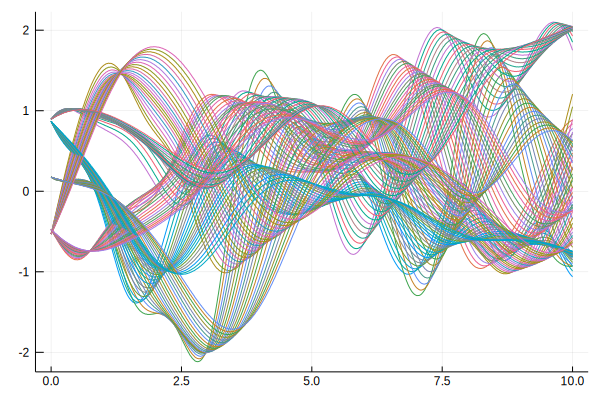

In [5]:
plot(Xs, f(Xs))
p = plot()
for l in 1:0.05:2
    f =  GP(rbf([l], [1.]))
    Random.seed!(1234);
    plot!(p, Xs, rand(f(Xs), 5), legend=false)
end
display(p)

In [26]:
anim = @animate for _l in -2:0.025:2
    f = GP(rbf([10^_l], [1.]))
    Random.seed!(1234);
    plot(Xs, rand(f(Xs), 10), ylims=(-3.5,3.5))
end
gif(anim, "gifs/lengthscales.gif")

┌ Info: Saved animation to 
│   fn = /home/nath/Projekte/julia-gps/notebooks/gifs/lengthscales.gif
└ @ Plots /home/nath/.julia/packages/Plots/Ih71u/src/animation.jl:95


Plots.AnimatedGif("/home/nath/Projekte/julia-gps/notebooks/gifs/lengthscales.gif")

## Better: Follow Philipp's Guide!

In [7]:
f = GP(rbf([1], [1.]))
N = length(Xs)
C = cholesky(f(Xs).Σ)

Cholesky{Float64,Array{Float64,2}}
U factor:
1001×1001 UpperTriangular{Float64,Array{Float64,2}}:
 1.0  0.9999    0.9996      0.9991      …  4.54325e-44  3.72007e-44
  ⋅   0.014212  0.0282072   0.0422587      7.06928e-43  5.79481e-43
  ⋅    ⋅        0.00245631  0.00332176     9.64214e-43  7.91201e-43
  ⋅    ⋅         ⋅          0.00188311     2.22559e-42  1.82658e-42
  ⋅    ⋅         ⋅           ⋅             3.88569e-42  3.18954e-42
  ⋅    ⋅         ⋅           ⋅          …  5.44984e-42  4.47422e-42
  ⋅    ⋅         ⋅           ⋅             6.53841e-42  5.36904e-42
  ⋅    ⋅         ⋅           ⋅             7.37208e-42  6.05518e-42
  ⋅    ⋅         ⋅           ⋅             8.51179e-42  6.99339e-42
  ⋅    ⋅         ⋅           ⋅             1.04587e-41  8.59554e-42
  ⋅    ⋅         ⋅           ⋅          …  1.36074e-41  1.11864e-41
  ⋅    ⋅         ⋅           ⋅             1.83366e-41  1.50776e-41
  ⋅    ⋅         ⋅           ⋅             2.50681e-41  2.06169e-41
 ⋮                

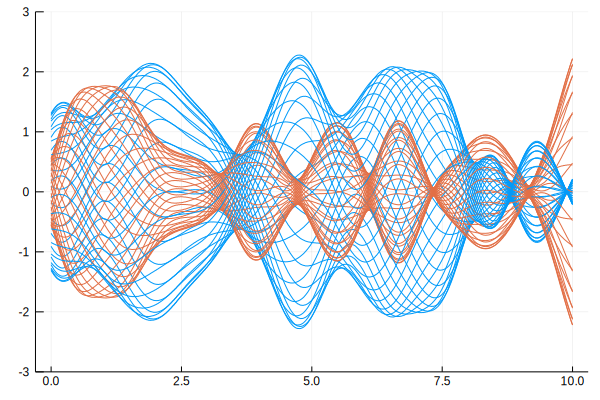

In [8]:
# Copy from the MATLAB code
function construct_samplepath(x, n=30)
    if length(size(x)) == 2
        d, n_samples = size(x)
    else
        d, n_samples = size(x), 1
    end
    
    r = sqrt(sum(x.^2))
    x = x ./ r
    t = randn(size(x))
    t = t - (t' * x) * x
    t = t ./ sqrt(sum(t.^2))
    s = LinRange(1e-3, 2π, n+1)
    t = s' .* t
    
    function exp_map(mu, E)
        D = size(E,1)
        theta = sqrt.(sum(E.^2, dims=1)) .+ 1e-6
        M = mu * cos.(theta) .+ E .* (sin.(theta)./theta)
        if (any(abs.(theta) .<= 1e-7))
            error("Not implemented")
        end
        return M
    end
    
    X = r .* exp_map(x,  t)
end

n = 30
x = randn(length(Xs),2)
#path = construct_samplepath(x, n)
paths = cat([construct_samplepath(col, n) for col in eachcol(x)]...; dims=3)

#anim = @animate for i in 1:n
#    u = X[:, i]
#    plot(Xs, f(Xs).μ + C.L * u, ylims=(-3, 3))
#end
#gif(anim, "/tmp/julia_gifs/jklj.gif")

p = plot()
for i in 1:n
    for j in 1:size(paths, 3)
        plot!(p, Xs, f(Xs).μ .+ C.L * paths[:, i, j], 
            ylims=(-3, 3), color=j, legend=false)
    end
end
display(p)

In [16]:
x = randn(length(Xs), 5)
n = 100
paths = cat([construct_samplepath(col, n) for col in eachcol(x)]...; dims=3)
anim = @animate for i in 1:n
    p = plot()
    for j in 1:size(paths, 3)
        plot!(p, Xs, f(Xs).μ .+ C.L * paths[:, i, j], 
            ylims=(-3, 3), color=j, legend=false)
    end
end
gif(anim, "gifs/wiggly_prior.gif")

┌ Info: Saved animation to 
│   fn = /home/nath/Projekte/julia-gps/notebooks/gifs/wiggly_prior.gif
└ @ Plots /home/nath/.julia/packages/Plots/Ih71u/src/animation.jl:95


Plots.AnimatedGif("/home/nath/Projekte/julia-gps/notebooks/gifs/wiggly_prior.gif")

# Old

### Posterior
First generate some evidence, then get a pretty posterior formulation.

In [17]:
_y = GPs.GP(GPs.constant_mean(-1.), GPs.rbf([0.5], [2])) + GPs.GP(GPs.noise([0.5]))
n = 10
X̂ = rand(n).*8 .+ 1
ŷ = rand(_y(X̂))
[X̂ ŷ];

In [18]:
struct Evidence
    gp::GP
    X::Array
    y::Array
end
←(gp::GP, obs::Tuple{Array, Array}) = Evidence(gp, obs[1], obs[2])
import Base.|
function |(gp::GP, evidence::Evidence)
    y = evidence.gp
    X̂, ŷ = evidence.X, evidence.y
    Δy = ŷ - gp.μ(X̂)
    K_inv = inv(Symmetric(y.k(X̂, X̂) + 1e-4*I))
    
    μ(x) = gp.μ(x) .+ gp.k(x, X̂) * K_inv * Δy
    k(x₁, x₂) = gp.k(x₁, x₂) - gp.k(x₁, X̂) * K_inv * gp.k(X̂, x₂)
    
    return GPs.GP(μ, k)
end

| (generic function with 18 methods)

In [19]:
f′ = f | (y ← (X̂, ŷ));

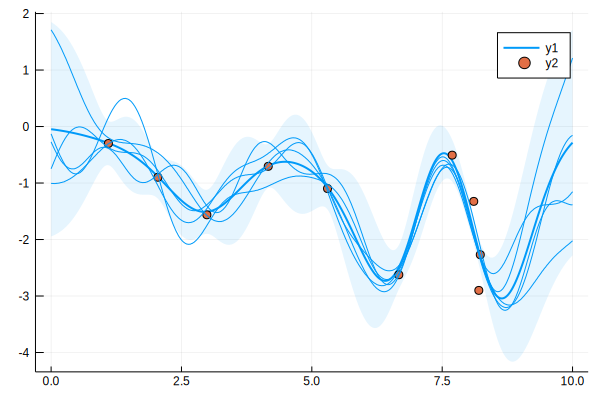

In [20]:
plot(Xs, f′(Xs))
scatter!(X̂, ŷ, color=2)
plot!(Xs, rand(f′(Xs), 5), color=1, label="")

In [22]:
C = cholesky(f′(Xs).Σ)
n = 100
paths = cat([construct_samplepath(col, n) for col in eachcol(x)]...; dims=3)
anim = @animate for i in 1:n
    p = plot()
    scatter!(X̂, ŷ, color=2)
    for j in 1:size(paths, 3)
        plot!(p, Xs, f′(Xs).μ .+ C.L * paths[:, i, j], 
            ylims=(-3, 3), color=j, legend=false)
    end
end
gif(anim, "gifs/wiggly_posterior.gif")

┌ Info: Saved animation to 
│   fn = /home/nath/Projekte/julia-gps/notebooks/gifs/wiggly_posterior.gif
└ @ Plots /home/nath/.julia/packages/Plots/Ih71u/src/animation.jl:95


Plots.AnimatedGif("/home/nath/Projekte/julia-gps/notebooks/gifs/wiggly_posterior.gif")